# SYDE 556/750 --- Assignment 1
**Student ID: 20773799**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/tcstewar/syde556-f21/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize # For question 2.1b)

# Fix the numpy random seed for reproducible results
np.random.seed(0)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$

Add equations here used to compute jbias and gain 

Using equation: 

$$J(x) = ax + J^{bias}$$ 

Given that maximum firing rate $a^{max}$ occurs at $x = 1$: 
It can be derived that: 

$$ J(1) = a + J^{bias} $$
$$ a = J(1) - J^{bias} $$

and

At x-intercept $x_{int}$, 

$$J(x_{int}) = ax_{int} + J^{bias} $$ 

$$ J^{bias} = J(x_{int})-ax_{int} $$

Plug this equation of $ J^{bias} $ into euqation for $a$: 

$$ a = J(1) - J(x_{int}) + ax_{int}  $$

Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.

For specific case $G[J] = \max(J, 0)$: 

$$  a^{max} = J(1) $$

$$  0 = J(x_{int}) $$

This means that $ a = J(1) - J(x_{int}) + ax_{int} $ can be simplified to: 

$$ a = a^{max} + ax_{int} $$
$$ a - ax_{int} = a^{max}  $$
$$ a = \frac{a^{max}} {1-x_{int}} $$

and 

$$ J^{bias} = -ax_{int} $$

In [2]:
class LinearNeuron(object): 
    max_firing_rate = 0
    alpha = 0
    j_bias = 0
    x_int = 0
    encoder = 0
    
    def __init__(self):
        # max firing a_max @ x=1
        self.max_firing_rate = np.random.uniform(low=100, high=200)
        # when a = 0, x_int: 
        self.x_int = np.random.uniform(low=-0.95, high=0.95) 
        self.encoder = np.random.choice([-1, 1]) 

        # solve for gain a: max_firing_rate - j_bias, isolate alpha 
        self.alpha = self.max_firing_rate / (1-self.x_int)
        # solve for j_bias 
        self.j_bias = -self.alpha * self.x_int 

In [3]:
def initLinearNeuron(X): 
    a = np.zeros(len(X))
    neu = LinearNeuron()
    for i,x in enumerate(X): 
        J = neu.encoder * neu.alpha * x + neu.j_bias 
        a[i] = max(J, 0)
    return a 

**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.

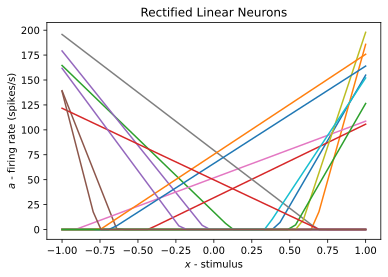

In [4]:
def generateNeurons(n, X): 
    np.random.seed(0)
    a = np.zeros([n, len(X)]) 
    for k in range(0,n):
        neu = LinearNeuron()
        for i,x in enumerate(X): 
            J = neu.encoder * neu.alpha * x + neu.j_bias 
            a[k][i] = max(J, 0)
    return a 

n = 16
step_size = 0.05
X = np.linspace(-1, 1, num=int(2/step_size))
A = generateNeurons(n, X)

for i in range(0, n): 
    plt.plot(X, A[i])
plt.xlabel('$x$ - stimulus')
plt.ylabel('$a$ - firing rate (spikes/s)')
plt.title('Rectified Linear Neurons');

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).

In [5]:
def identityDecoder(A, X):
    # find decoder D via least square 
    D = np.linalg.lstsq(A.T, X.T, rcond=None)[0].T 
    return D
    
d = identityDecoder(A, X)
print(d)

[-4.15084877e-06  9.89907077e-04 -5.68420407e-06  8.17719677e-05
  8.37250279e-06 -8.43261175e-05  1.15781622e-03 -1.62336159e-02
 -3.36120452e-06  5.34706641e-06  5.41819726e-05  3.82622790e-03
  3.75506118e-06  1.87846322e-02 -1.41994700e-05 -6.77118020e-04]


**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.

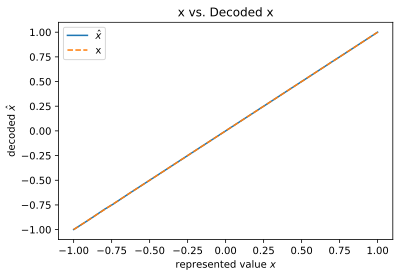

In [6]:
X_hat = d@A

plt.plot(X, X_hat)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x');

rmse: 0.0006274899677708264


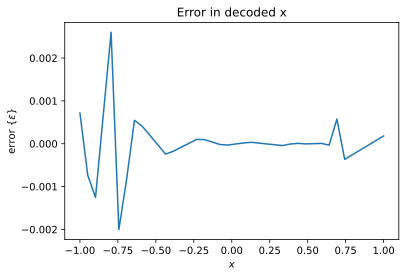

In [7]:
plt.plot(X, X_hat-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x');

def calculateRMSE(x, x_pred): 
    return np.sqrt(((x_pred-x) ** 2).mean())

rmse_d_a = calculateRMSE(X, X_hat)
print("rmse: " + str(rmse_d_a))

**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.

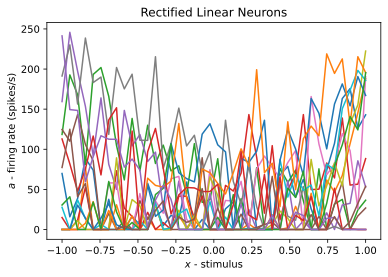

In [8]:
def createANoise(A, X, sigma_const): 
    np.random.seed(0)
    A_noise = A + np.random.normal(loc=0, scale=sigma_const*np.max(A), size = A.shape)
    for k in range(0, A.shape[0]): 
        for i,x in enumerate(X): 
            A_noise[k][i] = max(A_noise[k][i], 0)
    
    return A_noise

A_Noise = createANoise(A, X, 0.2)

# checking noisy A graph
for i in range(0, n): 
    plt.plot(X, A_Noise[i])
plt.xlabel('$x$ - stimulus')
plt.ylabel('$a$ - firing rate (spikes/s)')
plt.title('Rectified Linear Neurons');

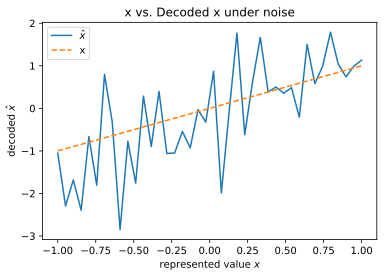

In [9]:
# re-generate graphs from d)
X_hat_Anoise = d@A_Noise

plt.plot(X, X_hat_Anoise)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x under noise');


rmse: 0.883508586370228


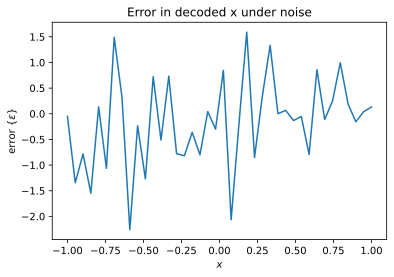

In [10]:
plt.plot(X, X_hat_Anoise-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x under noise');

rmse_d_aNoise = calculateRMSE(X, X_hat_Anoise)
print("rmse: " + str(rmse_d_aNoise))

**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.

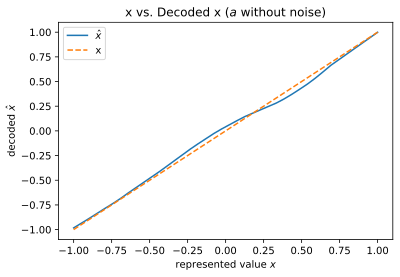

In [11]:
def decoderWithNoise(A, X, sigma_const):
    # find decoder D via least square 
    n, N = A.shape #A is a nxN matrix 
    sigma = sigma_const*np.max(A) 
    D = np.linalg.lstsq(A@A.T + 0.5*N*np.square(sigma)*np.eye(n), A@X.T, rcond=None)[0].T
    return D

# decoder that accounts noise on regular A -- d) plots
d_decoderWithNoise = decoderWithNoise(A, X, 0.2)
X_decoderWithNoise = d_decoderWithNoise@A

plt.plot(X, X_decoderWithNoise)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x ($a$ without noise)');

rmse: 0.034754119734143524


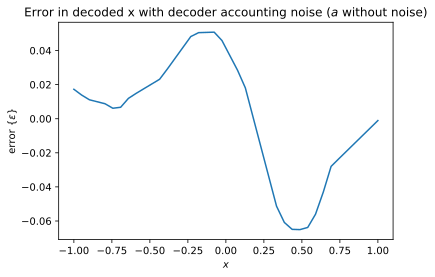

In [12]:
plt.plot(X, X_decoderWithNoise-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x with decoder accounting noise ($a$ without noise)');

rmse_dNoise_a = calculateRMSE(X, X_decoderWithNoise)
print("rmse: " + str(rmse_dNoise_a))

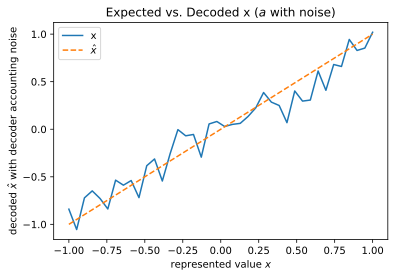

In [13]:
# decoder that accounts noise on A_noise -- e) plots
X_decoderWithNoise_ANoise = d_decoderWithNoise@A_Noise
plt.plot(X, X_decoderWithNoise_ANoise)
plt.plot(X, X, linestyle='dashed')
plt.legend(['x', '$\^{x}$'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$ with decoder accounting noise')
plt.title('Expected vs. Decoded x ($a$ with noise)');

rmse: 0.14672057808520217


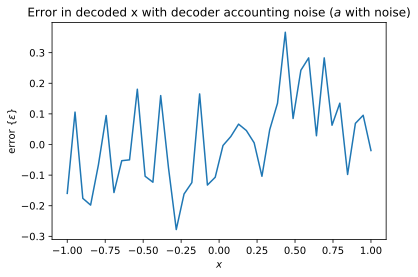

In [14]:
plt.plot(X, X-X_decoderWithNoise_ANoise)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x with decoder accounting noise ($a$ with noise)');

rmse_dNoise_aNoise = calculateRMSE(X, X_decoderWithNoise_ANoise)
print("rmse: " + str(rmse_dNoise_aNoise))

**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.

In [15]:
results = {1: ["d", rmse_d_a, rmse_d_aNoise],
           2: ["d accounting noise", rmse_dNoise_a, rmse_dNoise_aNoise ]}
print ("{:<20} {:<25} {:<25}".format('','A','A_Noise'))
for k, v in results.items():
    d, rmse_a, rmse_anoise = v
    print ("{:<20} {:<25} {:<25}".format(d, rmse_a, rmse_anoise))

                     A                         A_Noise                  
d                    0.0006274899677708264     0.883508586370228        
d accounting noise   0.034754119734143524      0.14672057808520217      


When using the decoder without accounting for noise computed with noiseless neuron data to decode the same data (i.e. using d to decode A), the resulting RMSE is always the lowest. However when noise is present (i.e. A_Noise), the same decoder performance is significantly impacted as we get a large RMSE. 

When decoder computation accounts for the noise, the measured RMSE values change. When decoder takes noise into account, RMSE is significantly lowered when decoding the noisy neurons. This decoder when used to decode noiseless neurons performs better than decoding noisy neurons, but its RMSE value is larger than decoding with the original decoder. 

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.

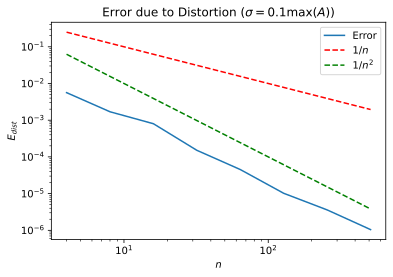

In [16]:
n_values = [4,8,16,32,64,128,256,512]


def computedErrors(A, X, d, sigma): 
    X_hat = d @ A
    #E_dist = 0.5 * np.mean(np.square(X - np.sum(d @ A)))
    E_dist = 0.5 * np.mean(np.square(X - d @ A))
    E_noise = 0.5 * np.square(sigma) * np.sum(np.square(d))

    return E_dist, E_noise


def createErrorGraphs(sigma): 
    E_dist = np.zeros(len(n_values))
    E_noise = np.zeros(len(n_values))
    for i,n in enumerate(n_values): 
        Edist_i = [0] * 5
        Enoise_i = [0] * 5
        for j in range(0,5):
            A_trial = generateNeurons(n,X)
            d = decoderWithNoise(A_trial, X, sigma)
            Ed, En = computedErrors(A_trial, X, d, sigma)
            Edist_i += Ed
            Enoise_i += En
        E_dist[i] = np.mean(Edist_i)
        E_noise[i] = np.mean(Enoise_i)
    
    return E_dist, E_noise

N_inv = np.zeros(len(n_values))
N_inv2 = np.zeros(len(n_values))

for i,n in enumerate(n_values):
    N_inv[i] = (n**(-1))
    N_inv2[i] = (n**(-2))

E_dist_a, E_noise_a = createErrorGraphs(0.1)
    
plt.loglog(n_values, E_dist_a, label = "Error")
plt.loglog(n_values,N_inv, 'r--', label="1/$n$")
plt.loglog(n_values,N_inv2, 'g--', label="1/$n^2$")
plt.legend()
plt.xlabel('$n$')
plt.ylabel('$E_{dist}$')
plt.title('Error due to Distortion ($\sigma = 0.1 \max(A)$)');

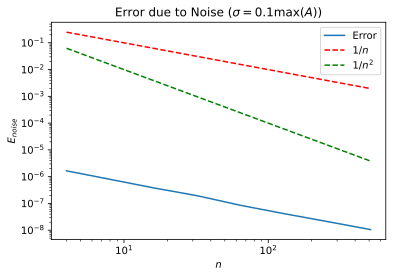

In [17]:
plt.loglog(n_values, E_noise_a, label = "Error")
plt.loglog(n_values,N_inv, 'r--', label="1/$n$")
plt.loglog(n_values,N_inv2, 'g--', label="1/$n^2$")
plt.legend()
plt.xlabel('$n$')
plt.ylabel('$E_{noise}$')
plt.title('Error due to Noise ($\sigma = 0.1 \max(A)$)');

**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.

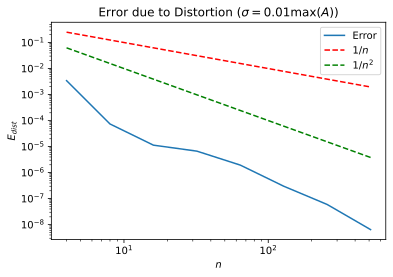

In [18]:
E_dist_b, E_noise_b = createErrorGraphs(0.01)
    
plt.loglog(n_values, E_dist_b, label = "Error")
plt.loglog(n_values,N_inv, 'r--', label="1/$n$")
plt.loglog(n_values,N_inv2, 'g--', label="1/$n^2$")
plt.legend()
plt.xlabel('$n$')
plt.ylabel('$E_{dist}$')
plt.title('Error due to Distortion ($\sigma = 0.01 \max(A)$)');

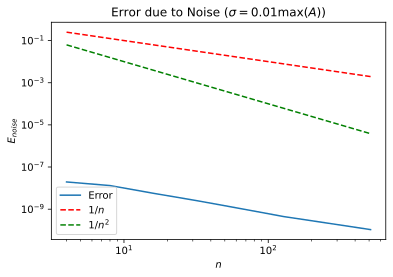

In [19]:
plt.loglog(n_values, E_noise_b, label = "Error")
plt.loglog(n_values,N_inv, 'r--', label="1/$n$")
plt.loglog(n_values,N_inv2, 'g--', label="1/$n^2$")
plt.legend()
plt.xlabel('$n$')
plt.ylabel('$E_{noise}$')
plt.title('Error due to Noise ($\sigma = 0.01 \max(A)$)'); 

**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?

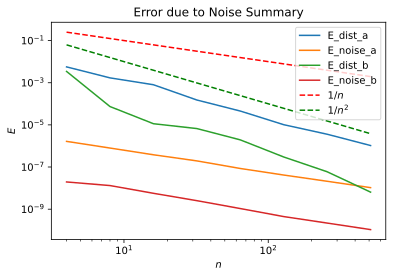

In [20]:
plt.loglog(n_values, E_dist_a, label = "E_dist_a")
plt.loglog(n_values, E_noise_a, label = "E_noise_a")
plt.loglog(n_values, E_dist_b, label = "E_dist_b")
plt.loglog(n_values, E_noise_b, label = "E_noise_b")
plt.loglog(n_values,N_inv, 'r--', label="1/$n$")
plt.loglog(n_values,N_inv2, 'g--', label="1/$n^2$")
plt.legend()
plt.xlabel('$n$')
plt.ylabel('$E$')
plt.title('Error due to Noise Summary'); 

In both a) and b), the static distortion error curves are proportional to the $1/n^2$ curve and the error due to noise curves are proportional to $1/n$. When the standard deviation $\sigma$ of noise added to the neural populations decreases from $0.1 \max(A)$ to $0.01 \max(A)$, the values of the error due to noise are significantly lowered (summary graph line orange and red). This makes sense because the term $E_{noise}$ is an estimate of the amount of error caused by a Gaussian distributed noise with variance $\sigma^2$. 
The static distortion errors are caused by the shape of the neural tuning curves and trying to decode the linear identity function using a linear decoder. When standard deviation $\sigma$ decreases, the error also decreases since lower the $\sigma$, closer the tuning curves are to the case where no noise is considered. In the case where no noise is accounted for in computing decoders, the static distortion will be minimized, but it is not realistic if noise is not accounted for in the decoding process. 

## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.

Using equations: 

$$ G[J] = \begin{cases} {\frac{1}{\tau_\mathrm{ref}-\tau_\mathrm{RC}\ln(1-\frac{1}J)}} &\mbox{if } J > 1 \,, \\ 0 &\mbox{otherwise} \,.\end{cases} $$

and 

$$J(x) = ax + J^{bias}$$ 

Given that maximum firing rate $a^{max}$ occurs at $x = 1$: 
It can be derived that: 

$$ J(1) = a + J^{bias} $$

and

$$ a^{max} = G[J(1)] = \frac{1}{\tau_\mathrm{ref}-\tau_\mathrm{RC}\ln(1-\frac{1}{a + J^{bias}})} $$

Simplify this equation to solve for $a + J^{bias}$: 

$$ \frac{1}{a^{max}} = \tau_\mathrm{ref}-\tau_\mathrm{RC}\ln(1-\frac{1}{a + J^{bias}}) $$
$$ \frac{\tau_\mathrm{ref}-\frac{1}{a^{max}}}{\tau_\mathrm{RC}} = \ln(1-\frac{1}{a + J^{bias}}) $$

$$ \frac{\tau_\mathrm{ref}-\frac{1}{a^{max}}}{\tau_\mathrm{RC}} = \ln(1-\frac{1}{a + J^{bias}}) $$

$$ e^{\frac{\tau_\mathrm{ref}-\frac{1}{a^{max}}}{\tau_\mathrm{RC}}} = 1-\frac{1}{a + J^{bias}} $$

$$ \frac{1}{1- e^{\frac{\tau_\mathrm{ref}-\frac{1}{a^{max}}}{\tau_\mathrm{RC}}}} = a + J^{bias} $$

$$ \frac{1}{1- e^{\frac{\tau_\mathrm{ref}{a^{max}}-1}{\tau_\mathrm{RC}{a^{max}}}}} = a + J^{bias} $$ 

At x-intercept $x_{int}$, 

$$J(x_{int}) = ax_{int} + J^{bias} = 0 $$ 

$$ J^{bias} = -ax_{int} $$

Plug this equation of $ J^{bias} $ into euqation for $a + J^{bias}$ to get equation for $a$: 

$$ a - ax_{int} = \frac{1}{1- e^{\frac{\tau_\mathrm{ref}{a^{max}}-1}{\tau_\mathrm{RC}{a^{max}}}}} $$
$$ a = \frac{1}{(1- e^{\frac{\tau_\mathrm{ref}{a^{max}}-1}{\tau_\mathrm{RC}{a^{max}}}})({1-x_{int}})} $$

and find $J^{bias}$ from above equation $ J^{bias} = -ax_{int} $ again: 
$$ J^{bias} = -ax_{int} = -\frac{x_{int}}{(1- e^{\frac{\tau_\mathrm{ref}{a^{max}}-1}{\tau_\mathrm{RC}{a^{max}}}})({1-x_{int}})} $$



In [21]:
class LIFNeuron(object): 
    a_max = 0
    alpha = 0
    j_bias = 0
    x_int = 0
    encoder = 0
    
    def __init__(self, tau_ref, tau_rc):
        # max firing a_max @ x=1
        self.a_max = np.random.uniform(low=100, high=200)
        # when a = 0, x_int: 
        self.x_int = np.random.uniform(low=-0.95, high=0.95) 
        self.encoder = np.random.choice([-1, 1]) 
        
        # solve for gain a: 
        demon_p1 = 1 - np.exp((self.a_max*tau_ref - 1)/(self.a_max*tau_rc))
        demon_p2 = 1 - self.x_int
        self.alpha = 1/(demon_p1*demon_p2)
        
        # solve for j_bias 
        self.j_bias = -self.alpha * self.x_int 

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.

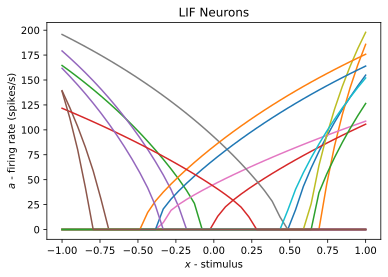

In [22]:
def generateLIFNeurons(n, X, tau_ref, tau_rc): 
    np.random.seed(0)
    a = np.zeros([n, len(X)]) 
    for k in range(0,n):
        neu = LIFNeuron(tau_ref, tau_rc)
        for i,x in enumerate(X): 
            J = neu.encoder * neu.alpha * x + neu.j_bias 
            if J > 1: 
                a[k][i] = (tau_ref - tau_rc*np.log(1-1/J))**(-1)
            else: 
                a[k][i] = 0
    return a 

n = 16
tau_ref = 0.002
tau_rc = 0.02
A_LIF = generateLIFNeurons(n, X, tau_ref, tau_rc)

for i in range(0, n): 
    plt.plot(X, A_LIF[i])
plt.xlabel('$x$ - stimulus')
plt.ylabel('$a$ - firing rate (spikes/s)')
plt.title('LIF Neurons');

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.

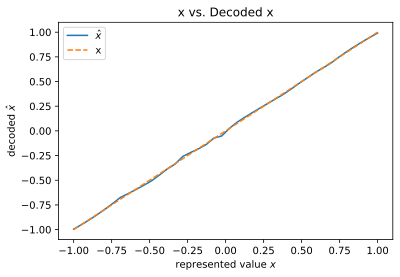

In [23]:
d_lif = identityDecoder(A_LIF, X)

X_hat_lif = d_lif@A_LIF

plt.plot(X, X_hat_lif)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x');

rmse: 0.009207213900424225


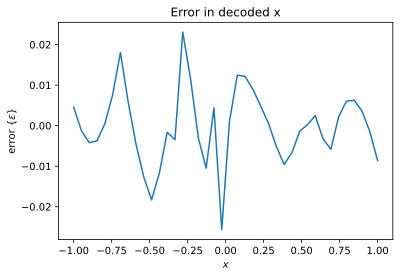

In [24]:
plt.plot(X, X_hat_lif-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x');

rmse_d_a_lif = calculateRMSE(X, X_hat_lif)
print("rmse: " + str(rmse_d_a_lif))

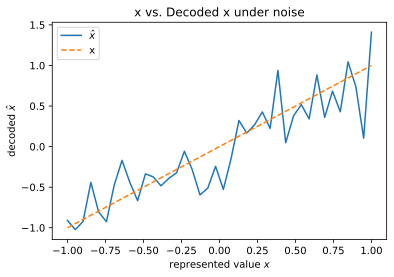

In [25]:
A_Noise_lif = createANoise(A_LIF, X, 0.2)

X_hat_Anoise_lif = d_lif@A_Noise_lif

plt.plot(X, X_hat_Anoise_lif)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$')
plt.title('x vs. Decoded x under noise');

rmse: 0.28576556108844087


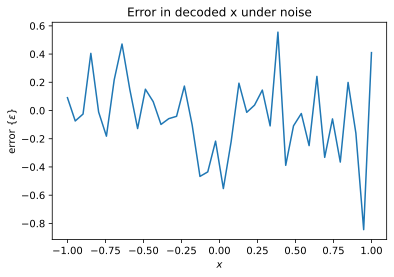

In [26]:
plt.plot(X, X_hat_Anoise_lif-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x under noise');

rmse_d_aNoise_lif = calculateRMSE(X, X_hat_Anoise_lif)
print("rmse: " + str(rmse_d_aNoise_lif))

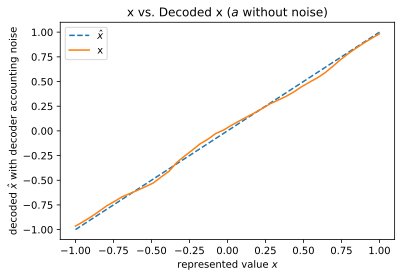

In [27]:
# decoder that accounts noise on regular A -- d) plots
d_decoderWithNoise_lif = decoderWithNoise(A_LIF, X, 0.2)
X_decoderWithNoise_lif = d_decoderWithNoise_lif@A_LIF

plt.plot(X, X, linestyle='dashed')
plt.plot(X, X_decoderWithNoise_lif)
plt.legend(['$\^{x}$','x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$ with decoder accounting noise')
plt.title('x vs. Decoded x ($a$ without noise)');

rmse: 0.034754119734143524


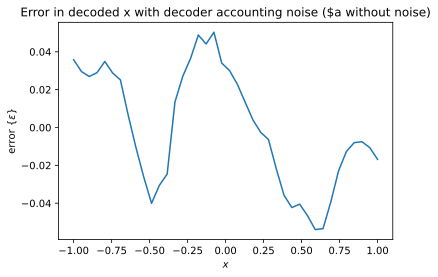

In [28]:
plt.plot(X, X_decoderWithNoise_lif-X)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x with decoder accounting noise ($a without noise)');

rmse_dNoise_a_lif = calculateRMSE(X, X_decoderWithNoise_lif)
print("rmse: " + str(rmse_dNoise_a))

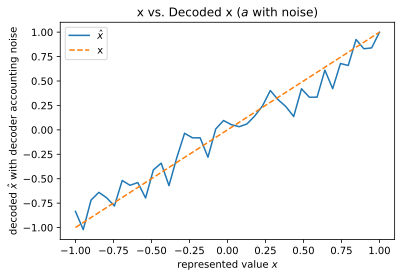

In [29]:
# decoder that accounts noise on A_noise -- e) plots
X_decoderWithNoise_ANoise_lif = d_decoderWithNoise_lif@A_Noise_lif
plt.plot(X, X_decoderWithNoise_ANoise_lif)
plt.plot(X, X, linestyle='dashed')
plt.legend(['$\^{x}$', 'x'])

plt.xlabel('represented value $x$')
plt.ylabel('decoded $\^{x}$ with decoder accounting noise')
plt.title('x vs. Decoded x ($a$ with noise)');

rmse: 0.1358290464808888


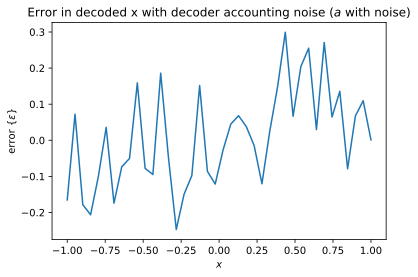

In [30]:
plt.plot(X, X-X_decoderWithNoise_ANoise_lif)
plt.xlabel('$x$')
plt.ylabel('error {$\epsilon$}')
plt.title('Error in decoded x with decoder accounting noise ($a$ with noise)');

rmse_dNoise_aNoise_lif = calculateRMSE(X, X_decoderWithNoise_ANoise_lif)
print("rmse: " + str(rmse_dNoise_aNoise_lif))

In [31]:
print("RMSE values table")
results_lif = {1: ["d", rmse_d_a_lif, rmse_d_aNoise_lif],
           2: ["d accounting noise", rmse_dNoise_a_lif, rmse_dNoise_aNoise_lif ]}
print ("{:<20} {:<25} {:<25}".format('','A','A_Noise'))
for k, v in results_lif.items():
    d, rmse_a, rmse_anoise = v
    print ("{:<20} {:<25} {:<25}".format(d, rmse_a, rmse_anoise))

RMSE values table
                     A                         A_Noise                  
d                    0.009207213900424225      0.28576556108844087      
d accounting noise   0.030901831602216014      0.1358290464808888       


# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.

In [32]:
class LIFNeuron_2D(object): 
    a_max = 0
    alpha = 0
    j_bias = 0
    x_int = 0
    encoder = 0
    
    def __init__(self, tau_ref, tau_rc):
        # max firing a_max @ x=1
        self.a_max = 100
        # when a = 0, x_int: 
        self.x_int = np.matrix([0,0])
        encoder = np.matrix([1, -1]) #angle = -25 when x=n, y=-n
        # normalize encoder: 
        self.encoder = encoder / np.linalg.norm(encoder)
        
        # solve for gain a: 
        demon_p1 = 1 - np.exp((self.a_max*tau_ref - 1)/(self.a_max*tau_rc))
        demon_p2 = 1 - np.linalg.norm(self.x_int)
        self.alpha = 1/(demon_p1*demon_p2)
        
        # solve for j_bias 
        self.j_bias = -self.alpha * np.linalg.norm(self.x_int)
        
    def set_encoder(self, en): 
        self.encoder = en
        
def generateLIFNeurons_2D(n, X, tau_ref, tau_rc): 
    np.random.seed(0)
    Y = X
    a = np.zeros([n,len(X),len(Y)])
    J = np.zeros([n,len(X),len(Y)])
    for k in range(0,n):
        neu = LIFNeuron_2D(tau_ref, tau_rc)
        for i, x in enumerate(X): 
            for j, y in enumerate(Y): 
                x_2d = np.matrix([x,y])
                J = neu.alpha * x_2d@neu.encoder.T  + neu.j_bias 
                if J > 1: 
                    a[k][i][j] = (tau_ref - tau_rc*np.log(1-1/J))**(-1)
                else: 
                    a[k][i][j] = 0
    return a 


In [33]:
n = 1
Y = X
# generate 1 2D neuron
A_2d = generateLIFNeurons_2D(n, X, tau_ref = 0.002, tau_rc = 0.02)

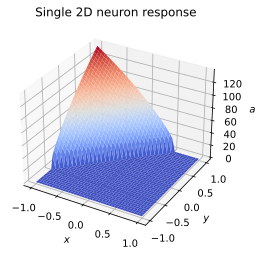

In [34]:
Xv,Yv = np.meshgrid(X, Y)

from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.plot_surface(Xv, Yv, A_2d[0], cmap=cm.coolwarm)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$a$")
ax.set_title("Single 2D neuron response");

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.

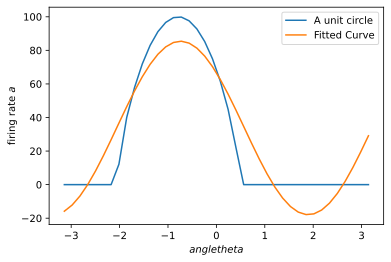

In [35]:
# angles on the unit circle: 
angle = np.linspace(-np.pi,np.pi,int(2/step_size))

import math
def generateLIFNeurons_2D_angles(n,angle,tau_ref,tau_rc):
    np.random.seed(0)
    a = np.zeros([len(angle)])
    neu = LIFNeuron_2D(tau_ref, tau_rc)
    for i,ang in enumerate(angle): 
        x = np.cos(ang)
        y = np.sin(ang)
        x_2d = np.matrix([x,y])
        J = neu.alpha * x_2d@neu.encoder.T  + neu.j_bias 
        if J > 1: 
            a[i] = (tau_ref - tau_rc*np.log(1-1/J))**(-1)
        else: 
            a[i] = 0
    return a
    
A_theta = generateLIFNeurons_2D_angles(n, angle, tau_ref = 0.002, tau_rc = 0.02)

from scipy.optimize import curve_fit 

def cos_curve(theta, c1, c2, c3, c4):
    return c1 * np.cos(c2 * theta + c3) + c4

popt, pcov = curve_fit(cos_curve, angle, A_theta)

plt.plot(angle, A_theta, label = "A unit circle")
plt.plot(angle, cos_curve(angle, *popt), label = "Fitted Curve")
plt.legend()
plt.xlabel("$angle theta$")
plt.ylabel('firing rate $a$');

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?

The curve fit with cosine is a good choice because the LIF neuron constructed in a) has a preferred direction at an angle of $-\frac{\pi}{4}$, which means that the maximum firing rate occurs at this angle. The transformed + translated consine curve (translate where the max cosine value occurs i.e. when $\theta = 0$ to when $\theta = -\frac{\pi}{4}$ can represent this maximum firing rate. There are differences from the ideal curve because the cosine curve can never 100% approximate the case where in some angles, the firing rate = 0 in ideal curve. The cosine curve only indicates how neuron responses sensitivity changes depending on the change in direction. 

## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).

In [36]:
import math as math
def generateEncoders(N):
    np.random.seed(0)
    encoders = np.zeros([2,N])
    for e in range(0,encoders.shape[1]):
        th = np.random.uniform(-np.pi, np.pi)
        x = math.cos(th)
        y = math.sin(th)
        encoders[0][e] = x
        encoders[1][e] = y
        
    return encoders

n = 100
Encoders = generateEncoders(n)
#print(Encoders)

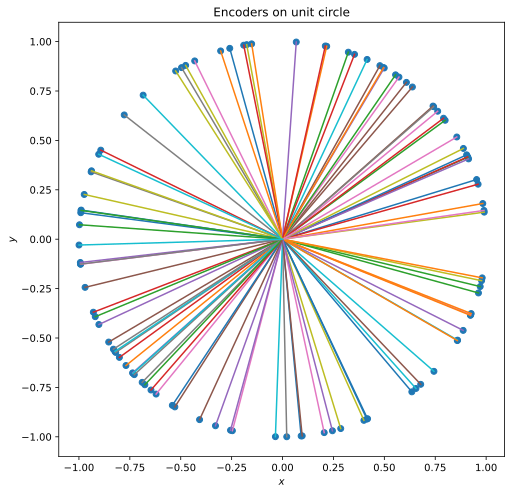

In [37]:
p1 = plt.figure(figsize=(8,8))
plt.scatter(Encoders[0,:], Encoders[1,:], figure=p1)

for i in range(0, Encoders.shape[1]): 
    plt.plot([0, Encoders[0][i]], [0, Encoders[1][i]], figure=p1)

plt.title("Encoders on unit circle")
plt.xlabel("$x$")
plt.ylabel("$y$");

**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.

In [38]:
def decoderWithNoise_2D(A, X, sigma_const):
    # find decoder D via least square 
    n, N = A.shape #A is a nxN matrix 
    sigma = sigma_const*np.max(A) 
    D = np.linalg.lstsq(A@A.T + 0.5*N*np.square(sigma)*np.eye(n), A@X.T, rcond=None)[0].T
    return D

def generateLIFNeurons_2D_vec(n, vec, encoders, tau_ref=0.002, tau_rc=0.02): 
    # vec is a 2*N array where N is number of x-y samples 
    # encoders need to be unit vector 
    np.random.seed(0)
    a = np.zeros([n,vec.shape[1]])
    #J = np.zeros([n,vec.shape[1]])
    for k in range(0,n):
        neu = LIFNeuron_2D(tau_ref, tau_rc)
        neu.set_encoder(np.array([encoders[0][k], encoders[1][k]]))
        for i in range(0, vec.shape[1]): 
            x_2d = np.matrix([vec[0][i],vec[1][i]])
            J = neu.alpha * x_2d@neu.encoder.T  + neu.j_bias 
            if J > 1: 
                a[k][i] = (tau_ref - tau_rc*np.log(1-1/J))**(-1)
            else: 
                a[k][i] = 0
    return a 


vectors = np.zeros([2,1600])
#randomly generate 1600 vectors 
np.random.seed(0)
for i in range(0, vectors.shape[1]):
    vectors[0][i] = np.random.uniform(low=-1, high=1)
    vectors[1][i] = np.random.uniform(low=-1, high=1)

# n need to = Encoders length
A_sample = generateLIFNeurons_2D_vec(100, vectors, Encoders, tau_ref = 0.002, tau_rc = 0.02)
d_2D = decoderWithNoise_2D(A_sample, vectors, 0.2)

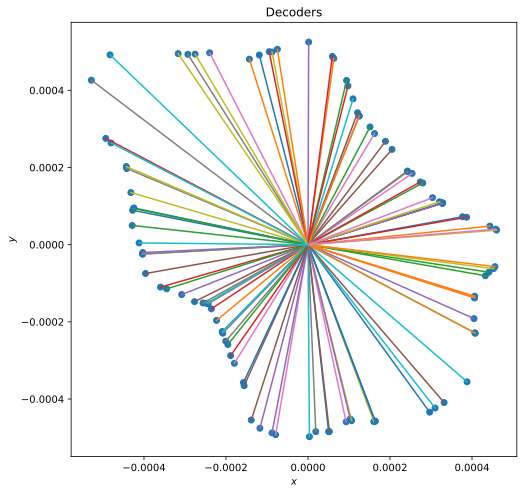

In [39]:
p2=plt.figure(figsize=(8,8))
plt.scatter(d_2D[0, :], d_2D[1, :], figure=p2)

for i in range(0, d_2D.shape[1]): 
    plt.plot([0, d_2D[0][i]], [0, d_2D[1][i]], figure=p2)

plt.title("Decoders")
plt.xlabel("$x$")
plt.ylabel("$y$");

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?

The decoding vectors have a much smaller magnitude in comparison to the encoding vectors. However, the spacing between each vector in the decoders are very similar to that of the encoders. This suggests that they have similar directions. The left figure below shows the encoders again, and the right figure shows the normalized decoders. 

In [40]:
d_2D_norm = np.zeros([100,2])
for i,x in enumerate(d_2D.T): 
    if x[0] == 0 or x[1]==0: 
        x = x
    else: 
        k = x / np.linalg.norm(x)
        x = k
    d_2D_norm[i] = x

d_2D_norm = d_2D_norm.T

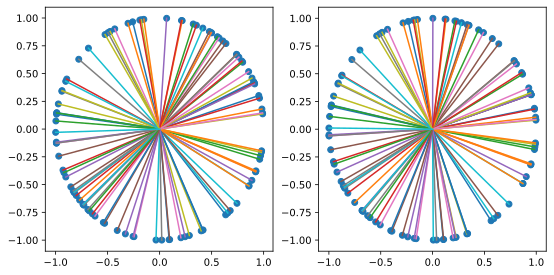

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5))
axes[0].scatter(Encoders[0,:], Encoders[1,:])

for i in range(0, Encoders.shape[1]): 
    axes[0].plot([0, Encoders[0][i]], [0, Encoders[1][i]])
    
axes[1].scatter(d_2D_norm[0, :], d_2D_norm[1, :])

for i in range(0, d_2D_norm.shape[1]): 
    axes[1].plot([0, d_2D_norm[0][i]], [0, d_2D_norm[1][i]])

**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.

In [42]:
vectors_unit = np.zeros([2,20])
#randomly generate 20 vectors 
np.random.seed(0)
for i in range(0, vectors_unit.shape[1]):
    ang = np.random.uniform(low=-np.pi, high=np.pi)
    length = np.random.uniform(low=0, high=1)
    vectors_unit[0][i] = length*math.cos(ang)
    vectors_unit[1][i] = length*math.sin(ang)

# n need to = Encoders length
A_unit = generateLIFNeurons_2D_vec(100, vectors_unit, Encoders, tau_ref = 0.002, tau_rc = 0.02)

vectors_unit_hat = d_2D@A_unit

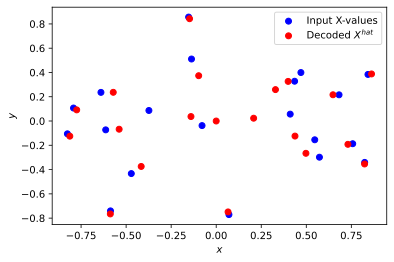

In [43]:
plt.figure()
plt.scatter(vectors_unit[0, :],vectors_unit[1, :], color='blue', label = "Input X-values");
plt.scatter(vectors_unit_hat[0, :],vectors_unit_hat[1, :], color='red', label = "Decoded $X^{hat}$");
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [44]:
def compute_rmse_2D(x_pred, x):
    diff = x_pred-x
    temp = sum(diff**2)/2 
    rmse = np.sqrt(temp.mean())
    
    return rmse

In [45]:
compute_rmse_2D(vectors_unit_hat, vectors_unit)

0.06982674512680746

**e) Using encoders as decoders.** Repeat part d) but use the *encoders* as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.

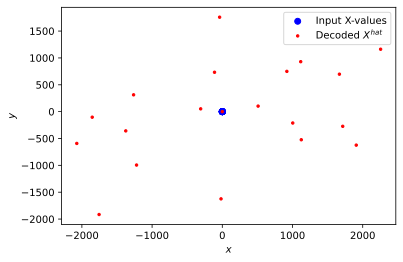

In [46]:
vectors_unit_hat_encoder = Encoders@A_unit

plt.figure()
plt.scatter(vectors_unit[0, :],vectors_unit[1, :], color='blue', label = "Input X-values");
plt.scatter(vectors_unit_hat_encoder[0, :],vectors_unit_hat_encoder[1, :], color='red', label = "Decoded $X^{hat}$", s=6);
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [47]:
vectors_unit_hat_encoder_norm = np.zeros([20,2])
for i,x in enumerate(vectors_unit_hat_encoder.T): 
    if x[0] == 0 or x[1]==0: 
        x = x
    else: 
        k = x / np.linalg.norm(x)
        x = k
    vectors_unit_hat_encoder_norm[i] = x

vectors_unit_hat_encoder_norm = vectors_unit_hat_encoder_norm.T

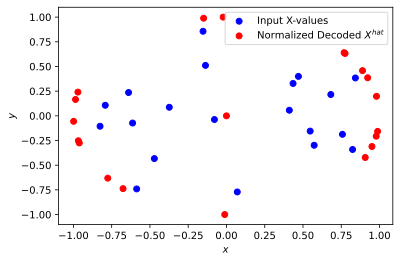

In [48]:
plt.figure()
plt.scatter(vectors_unit[0, :],vectors_unit[1, :], color='blue', label = "Input X-values");
plt.scatter(vectors_unit_hat_encoder_norm[0, :],vectors_unit_hat_encoder_norm[1, :], color='red', label = "Normalized Decoded $X^{hat}$");
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()

In [49]:
compute_rmse_2D(vectors_unit_hat_encoder_norm, vectors_unit)

0.245847730037726

**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?

The small error indicates that the encoders and optimal decoders have very similar angles that corresponds to where the maximum firing rate occurs. However, because the encoding vectors are unit vectors, they failed to account for the magnitude decoding needed to decode the max firing rate back to input vectors. For random unit vectors in high dimensional spaces, this direction information is also accounted for, but using those as decoders leads to losing all information such as the magnitude for the decoded vector, thus result in large error. 


Using the encoders as decoders is more convenient to use and significantly computationally less expensive than using the optical decoders. This is useful for cases where only direction of firing is of interest and the vectors are in high dimensional spaces. On the other hand, the optimal decoder is a simple linear decoding method that is supported by theoretical foundation, and results in significantly low error in comparison to other linear decoders. It is also easy to extend optimal decoding method to higher dimensional vectors decoding. 